## Kaggle Data Load

In [1]:
# kaggle api update
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 4.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=9dfdec80771f3fde211da49352b986ad56a95b0dee8975ea332ac5498d330e02
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [3]:
# kaggle api token upload
# 셀 실행 후 api token이 포함된 kaggle.json 파일 업로드 필요
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [4]:
# Data download
!kaggle competitions download -c nyc-taxi-trip-duration

 97% 83.0M/85.8M [00:01<00:00, 50.8MB/s]
100% 85.8M/85.8M [00:01<00:00, 72.1MB/s]


In [10]:
!unzip 'nyc-taxi-trip-duration.zip'

Archive:  nyc-taxi-trip-duration.zip
  inflating: sample_submission.zip   
  inflating: test.zip                
  inflating: train.zip               


In [5]:
## Other Package Install
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono g

## Library Import

In [6]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
import io
import base64
from IPython.display import HTML
from imblearn.under_sampling import RandomUnderSampler
# from subprocess import check_output
# import networkx as nx
# from matplotlib.animation import FuncAnimation, PillowWriter 

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Analysis

Dynamics-of-new-york-city-animation (https://www.kaggle.com/drgilermo/dynamics-of-new-york-city-animation) 참조

In [11]:
df = pd.read_csv("train.zip")

In [12]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [13]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [14]:
len(df)

1458644

In [15]:
# longitude와 latitude를 한정함으로써 극단적 이상치 제거
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
df = df[(df.pickup_longitude > xlim[0]) & (df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude > xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude > ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude > ylim[0]) & (df.dropoff_latitude < ylim[1])]

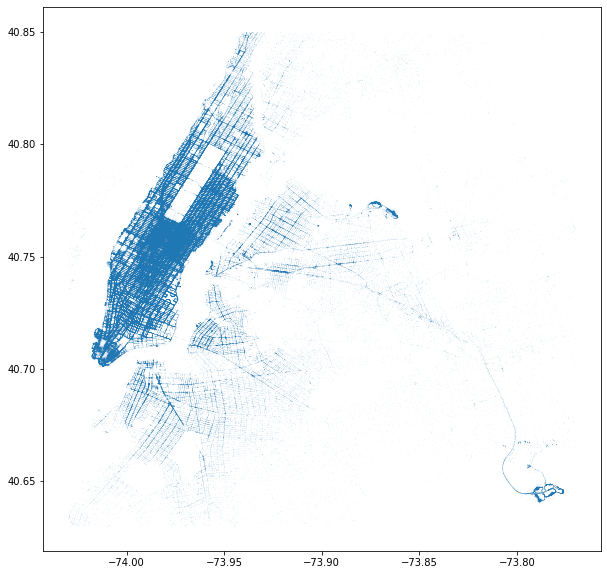

In [16]:
# pickup하고 dropoff한 모든 위치 시각화
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)
plt.figure(figsize = (10, 10))
plt.plot(longitude, latitude, '.', alpha=0.4, markersize=0.05)
plt.show()

In [17]:
# pickup, dropoff 상관없이 모든 위치를 기반으로 데이터프레임 생성
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

In [18]:
# 모든 지점들을 Kmeans로 클러스터링
kmeans = KMeans(n_clusters=15, random_state=2, n_init=10).fit(loc_df)

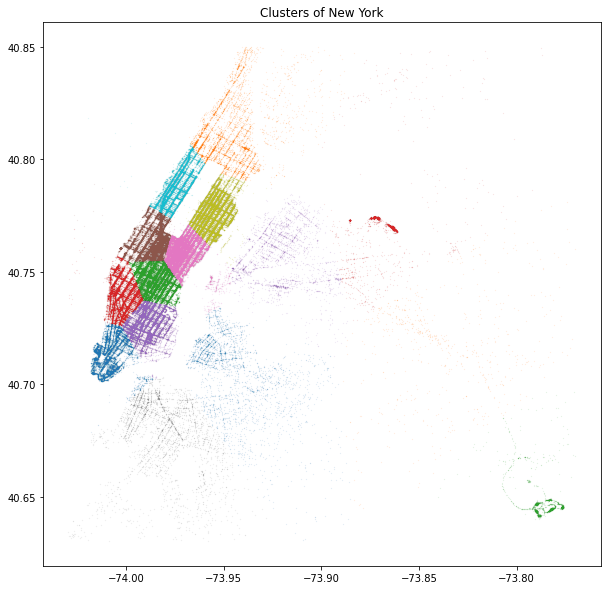

In [19]:
# Kmeans로 산출된 label을 바탕으로 클러스터 시각화
loc_df['label'] = kmeans.labels_

loc_df = loc_df.sample(200000)

plt.figure(figsize = (10, 10))

for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label], loc_df.latitude[loc_df.label == label], '.', alpha=0.3, markersize=0.3)
    
plt.title('Clusters of New York')
plt.show()

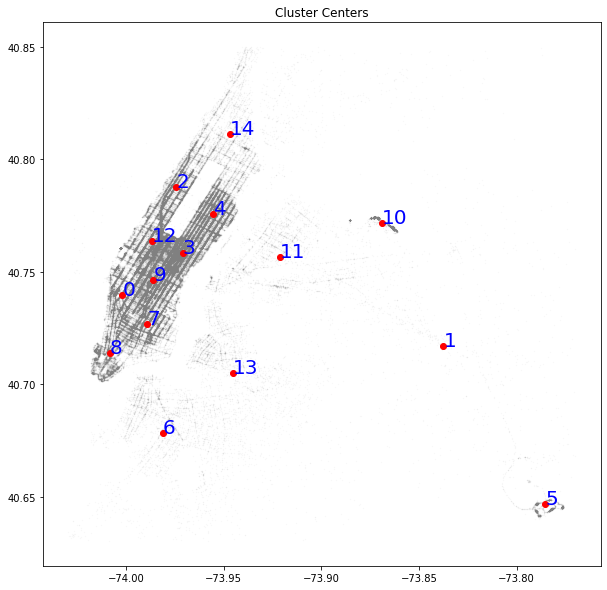

In [20]:
# Kmeans로 산출된 label을 바탕으로 클러스터 시각화
# 중심, 클러스터 번호 표시
fig, ax = plt.subplots(figsize=(10,10))

for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label], loc_df.latitude[loc_df.label == label], '.', alpha=0.4, markersize=0.1, color='gray')
    ax.plot(kmeans.cluster_centers_[label, 0], kmeans.cluster_centers_[label, 1], 'o', color='r')
    ax.annotate(label, (kmeans.cluster_centers_[label, 0], kmeans.cluster_centers_[label, 1]), color='b', fontsize=20)

ax.set_title('Cluster Centers')

plt.show()

In [21]:
# 전체 데이터에 대해 클러스터 예측 맵핑
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude', 'pickup_latitude']])
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude', 'dropoff_latitude']])
# 추후 시간별 변화를 보기 위한 시각화를 위해 picup_hour 컬럼 생성
df['pickup_hour'] = df.pickup_datetime.apply(lambda x: parser.parse(x).hour)

In [22]:
kmeans.cluster_centers_

array([[-74.00179404,  40.73952974],
       [-73.83756051,  40.71724437],
       [-73.97437315,  40.787492  ],
       [-73.97101559,  40.75836955],
       [-73.95548128,  40.77576434],
       [-73.78542632,  40.64661592],
       [-73.98108163,  40.67837841],
       [-73.98906619,  40.72695363],
       [-74.00814708,  40.71370949],
       [-73.9859628 ,  40.74654899],
       [-73.86900951,  40.77156337],
       [-73.92129402,  40.75657218],
       [-73.98657011,  40.76362855],
       [-73.94535302,  40.70506385],
       [-73.94673982,  40.81133908]])

In [23]:
# 클러스터 중심값 산출
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:,0]
clusters['y'] = kmeans.cluster_centers_[:,1]
clusters['label'] = range(len(clusters))
clusters.head(20)

,x,y,label
0,-74.001794,40.739530,0
1,-73.837561,40.717244,1
2,-73.974373,40.787492,2
3,-73.971016,40.758370,3
4,-73.955481,40.775764,4
5,-73.785426,40.646616,5
6,-73.981082,40.678378,6
7,-73.989066,40.726954,7
8,-74.008147,40.713709,8
9,-73.985963,40.746549,9


In [24]:
# 시각화를 위해 샘플링 다시 줄이기
loc_df = loc_df.sample(5000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin


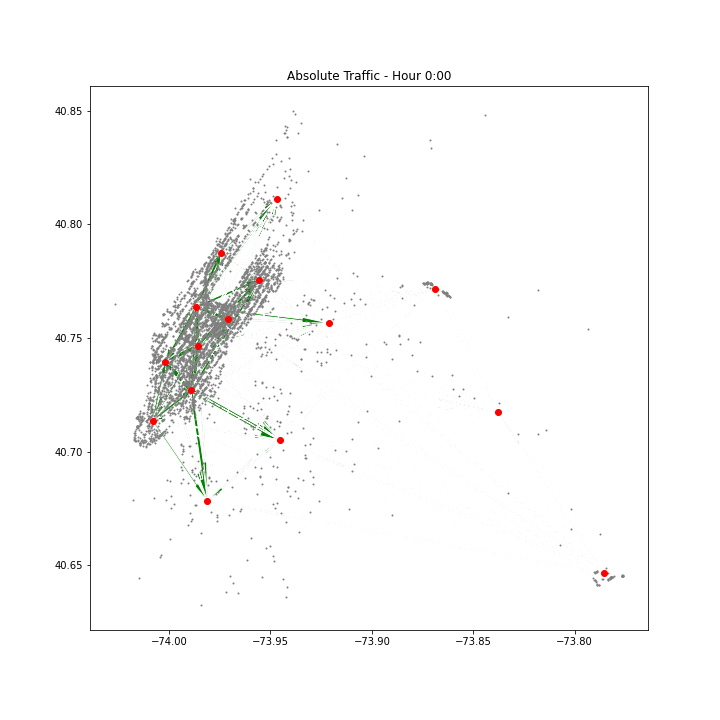

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [25]:
# 절대적인 트래픽 양 애니메이션 시각화
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Absolute Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10));
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray');
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r');


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = 15*pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()
ani.save('animation1.gif', writer='imagemagick', fps=2)
filename = 'animation1.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning


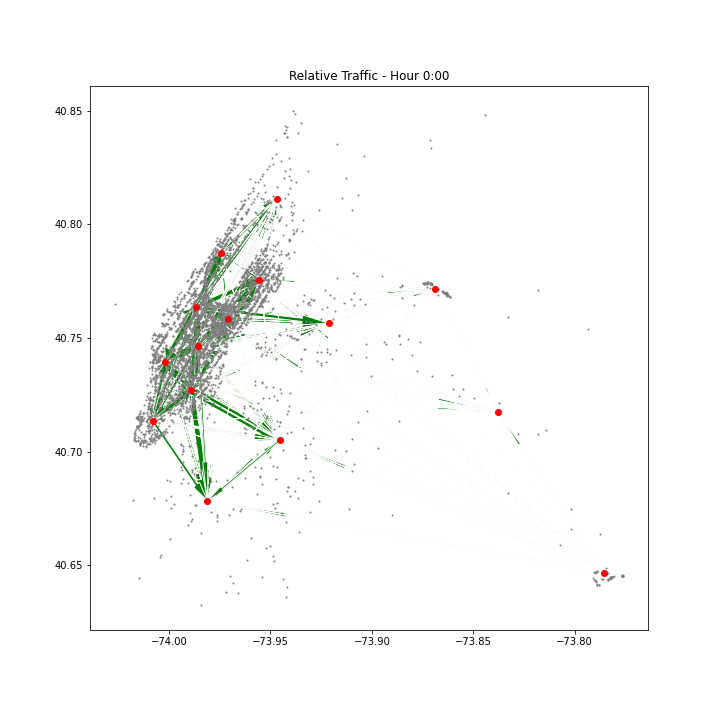

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [38]:
# 상대적인 트래픽 양 애니메이션 시각화
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Relative Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray')
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df[df.pickup_hour == hour]))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

In [27]:
# neighborhood 분석을 위한 longitude 정보 생성
neighborhood = {-74.0019368351: 'Chelsea',-73.837549761: 'Queens',-73.7854240738: 'JFK',-73.9810421975:'Midtown-North-West',-73.9862336241: 'East Village',
                -73.971273324:'Midtown-North-East',-73.9866739677: 'Brooklyn-parkslope',-73.8690098118: 'LaGuardia',-73.9890572967:'Midtown',-74.0081765545: 'Downtown'
                ,-73.9213024854: 'Queens-Astoria',-73.9470256923: 'Harlem',-73.9555565018: 'Uppe East Side',
               -73.9453487097: 'Brooklyn-Williamsburgt',-73.9745967889:'Upper West Side'}

In [28]:
# neighborhood 맵핑을 위한 KNN 모델 생성
rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(np.array(list(neighborhood.keys())).reshape(-1, 1), list(neighborhood.values()))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [29]:
# KNN을 이용한 neighborhood 맵핑 및 교통량 합산
df['pickup_neighborhood'] = neigh.predict(df.pickup_longitude.values.reshape(-1,1))
df['dropoff_neighborhood'] = neigh.predict(df.dropoff_longitude.values.reshape(-1,1))

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col)]))

In [30]:
rides_df

,Chelsea,Queens,JFK,Midtown-North-West,East Village,Midtown-North-East,Brooklyn-parkslope,LaGuardia,Midtown,Downtown,Queens-Astoria,Harlem,Uppe East Side,Brooklyn-Williamsburgt,Upper West Side,name
0,28526,228,950,18989,10622,7657,6141,1497,35963,22084,2119,2209,7998,2317,8742,Chelsea
1,27,375,93,55,37,20,5,120,33,24,43,15,43,15,41,Queens
2,1887,1221,2779,3578,2116,2351,743,1463,3207,1576,1749,993,2847,1244,2208,JFK
3,17496,416,2183,30833,13214,27005,6747,4206,35307,10196,2940,4654,22343,3898,23537,Midtown-North-West
4,10616,186,1168,13532,5619,8030,2622,2073,16225,5980,1625,1793,7099,1704,9138,East Village
5,7069,331,1346,24433,7833,25085,3355,2757,15474,4846,2669,6776,37879,5258,19356,Midtown-North-East
6,6225,116,439,8320,2907,4031,1612,802,8282,3397,1070,1026,3830,1108,4751,Brooklyn-parkslope
7,2055,950,793,5189,2958,3550,949,2620,3938,2256,2497,1230,3509,1591,3582,LaGuardia
8,37829,474,1833,41685,17402,18089,8724,3174,43352,22124,4277,4532,17223,4826,22242,Midtown
9,20509,187,869,10457,5776,5202,3295,1626,19725,21964,1095,1258,4792,1231,6167,Downtown


Text(0.5, 1.35, 'Neighborhoods Interaction')

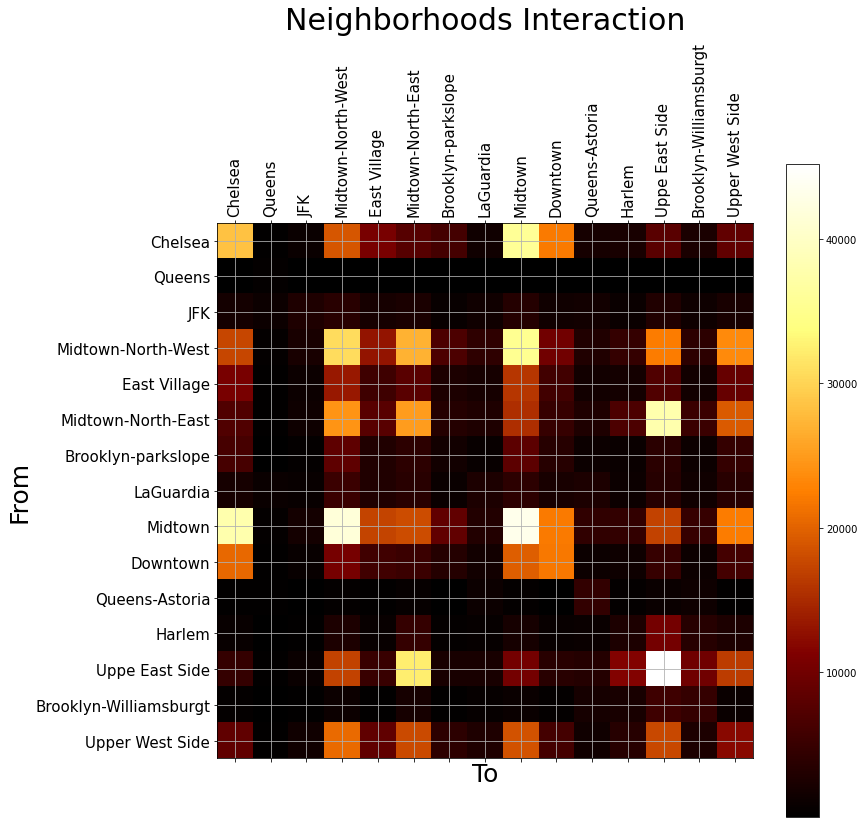

In [32]:
# 지역 간 교통량 시각화
fig,ax = plt.subplots(figsize = (12,12))
cax = ax.matshow(rides_df.drop('name',axis = 1),interpolation='nearest',cmap=cm.afmhot)
cbar = fig.colorbar(cax)
ax.grid('off')
ax.set_xticks(range(len(rides_df)))
ax.set_xticklabels(rides_df.name, rotation =90,fontsize = 15)
ax.set_yticks(range(len(rides_df)))
ax.set_yticklabels(rides_df.name,fontsize = 15)
ax.set_xlabel('To', fontsize = 25)
ax.set_ylabel('From', fontsize = 25)
ax.set_title('Neighborhoods Interaction', y=1.35, fontsize = 30)

In [33]:
rides_df.index = rides_df.name
rides_df = rides_df.drop('name', axis = 1)

Text(0.5, 1.0, 'Inbound and Outbound rides for each cluster')

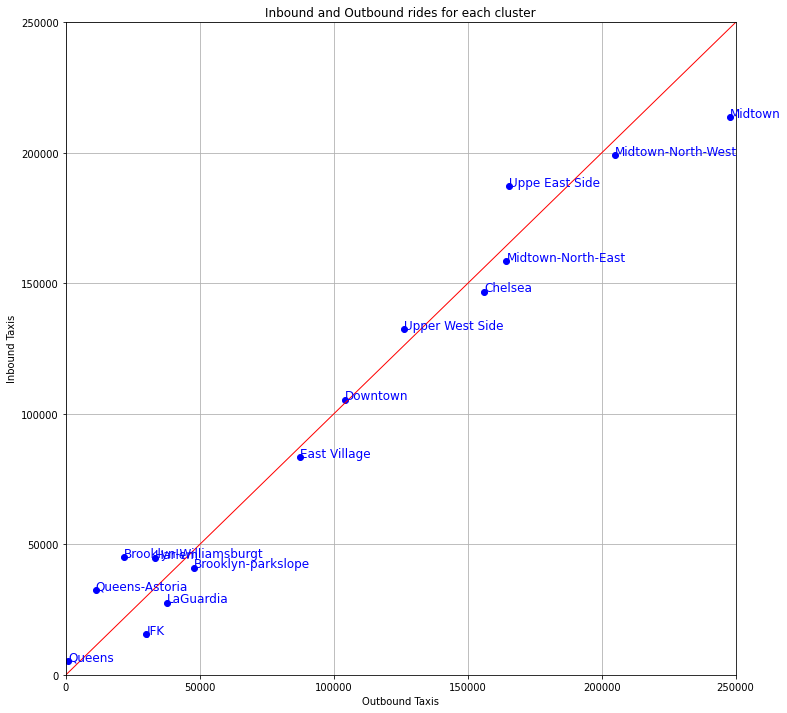

In [34]:
# Inbound, Outbound 비교
fig,ax = plt.subplots(figsize = (12,12))
for i in range(len(rides_df)):  
    ax.plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax.annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax.plot([0,250000],[0,250000], color = 'r', linewidth = 1)
ax.grid('off')
ax.set_xlim([0,250000])
ax.set_ylim([0,250000])
ax.set_xlabel('Outbound Taxis')
ax.set_ylabel('Inbound Taxis')
ax.set_title('Inbound and Outbound rides for each cluster')

In [37]:
df['pickup_month'] = df.pickup_datetime.apply(lambda x: parser.parse(x).month )

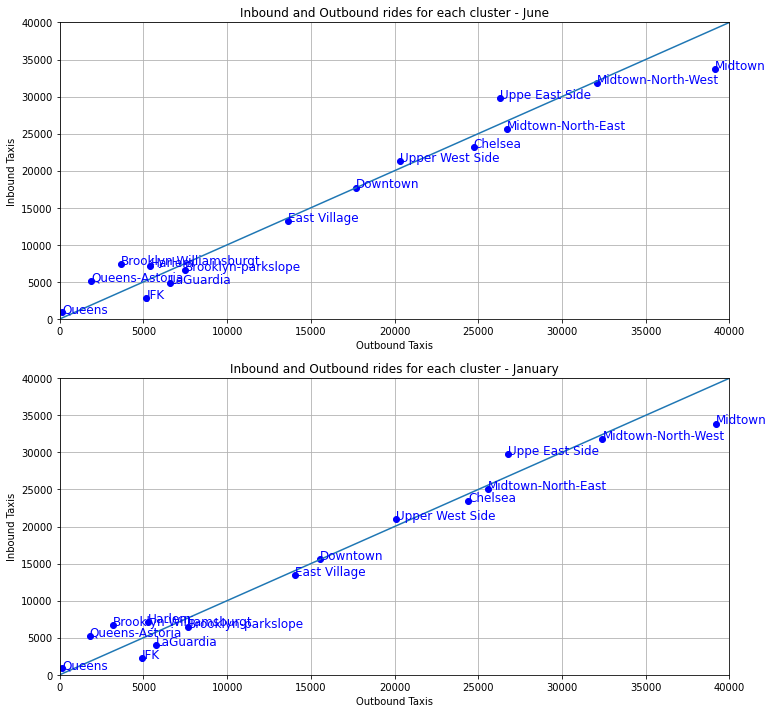

In [39]:
# 월에 따른 교통량 비교

fig,ax = plt.subplots(2,figsize = (12,12))

rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()
rides_df.index = rides_df.name


for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_month == 6)]))
for i in range(len(rides_df)):  
    ax[0].plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax[0].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax[0].grid('off')
ax[0].set_xlabel('Outbound Taxis')
ax[0].set_ylabel('Inbound Taxis')
ax[0].set_title('Inbound and Outbound rides for each cluster - June')
ax[0].set_xlim([0,40000])
ax[0].set_ylim([0,40000])
ax[0].plot([0,40000],[0,40000])


for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_month == 1)]))
rides_df = rides_df.drop('name', axis = 1)
for i in range(len(rides_df)):  
    ax[1].plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax[1].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax[1].grid('off')
ax[1].set_xlabel('Outbound Taxis')
ax[1].set_ylabel('Inbound Taxis')
ax[1].set_title('Inbound and Outbound rides for each cluster - January')
ax[1].set_xlim([0,40000])
ax[1].set_ylim([0,40000])
ax[1].plot([0,40000],[0,40000])


## Kaggle Submission

In [ ]:
# sample submission
# 시각화 예제이므로 따로 Submission할 파일은 없음
# !kaggle competitions submit -c nyc-taxi-trip-duration -f sample_submission.zip -m "Sample submission"

100% 2.49M/2.49M [00:00<00:00, 11.0MB/s]
Successfully submitted to New York City Taxi Trip Duration